### Read in the data and do some preprocessing

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

x = torch.tensor(train.drop(columns='label').values, dtype=torch.float32)
y = torch.tensor(train['label'], dtype=torch.long)

test_x = torch.tensor(test.values, dtype=torch.float32)

# normalize
x = x - 127.5 # center around 0 
x = x / 127.5 # scale to range [-1, 1]

test_x = test_x - 127.5
test_x = test_x / 127.5

n_labels = len(torch.unique(y))
n_samples = x.shape[0]

### Let's plot a digit 

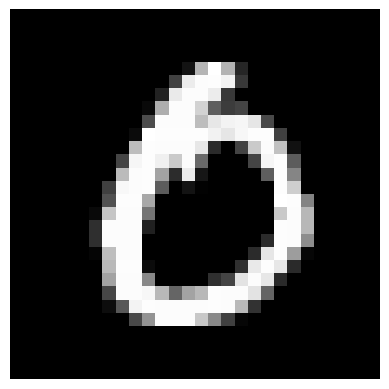

In [2]:
image = x[200].reshape(28, 28)  # Reshape to 2D (28x28)
def plot_digit(flattened_img):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


plot_digit(image)

### Augment the data 

In [5]:
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor


# transformations 
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33))
])

final_batch = torch.tensor([])
final_label = torch.tensor([], dtype=torch.long)
for i in range(5):
    rotated_batch = torch.stack([transform(img.reshape(1, 28, 28)) for img in x])
    rotated_batch = rotated_batch.reshape(len(rotated_batch), -1)
    final_batch = torch.cat([rotated_batch, final_batch])
    final_label = torch.cat([y, final_label])
    


x = torch.cat([x, final_batch])
y = torch.cat([y, final_label])

KeyboardInterrupt: 

### Let's define our neural net

In [7]:
class ConvNet(nn.Module): 
    
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2),
                nn.Dropout(0.25))
            
        self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2),
                nn.Dropout(0.25))
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1600, 256), 
            nn.ReLU(), 
            nn.Linear(256, 
            num_classes))
        
    def forward(self, x):
        
        batch_size, channels, height, width = x.shape
        
        out = self.layer1(x) # B, filters, height, width
        assert out.shape == (batch_size, 32, 14, 14)
        out = self.layer2(out)
        assert out.shape == (batch_size, 64, 5, 5)
        logits = self.linear(out)
        
        return logits

torch.manual_seed(1337)
model = ConvNet(n_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

### Train loop

In [ ]:
from sklearn.model_selection import train_test_split 

batch_size = 20
num_epochs = 30

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.1, random_state=1337)


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move validation data to GPU
train_x, val_x = train_x.to(device), val_x.to(device)
train_y, val_y = train_y.to(device), val_y.to(device)

model.train() # set model to training mode
model = model.to(device)

for i in range(num_epochs):
    
    preds = []
    losses = []
    for k in range(len(train_x) // batch_size):
    
        optimizer.zero_grad()

        start = k * batch_size
        end = start + batch_size
        sample = train_x[start:end]
        sample = sample.view(-1, 1, 28, 28)
        logits = model(sample)
        loss = F.cross_entropy(logits, train_y[start:end])
        loss.backward()
        optimizer.step()
        preds.extend(logits.argmax(dim=1).tolist())
        losses.append(loss.item())
    
    acc = len([pred for pred, label in zip(preds, train_y) if pred == label])/len(train_x)
    
    val_preds = []
    with torch.no_grad():
        for k in range(len(val_x) // batch_size):
            start = k * batch_size
            end = start + batch_size
            sample = val_x[start:end]
            sample = sample.view(-1, 1, 28, 28)
            logits = model(sample)
            val_preds.extend(logits.argmax(dim=1).tolist())
        
    val_acc = len([pred for pred, label in zip(val_preds, val_y) if pred == label])/len(val_x)
    
    scheduler.step(val_acc)
    
    print(f"Epoch {i}, Loss: {sum(losses)/len(losses)}, Acc: {acc}, Val Acc: {val_acc}")

Epoch 0, Loss: 0.37305540903060774, Acc: 0.8763888888888889, Val Acc: 0.9121031746031746
Epoch 1, Loss: 0.2388270163350187, Acc: 0.9218298059964727, Val Acc: 0.9261507936507937
Epoch 2, Loss: 0.2114572149439944, Acc: 0.930405643738977, Val Acc: 0.9302380952380952
Epoch 3, Loss: 0.19619371396176793, Acc: 0.9353880070546737, Val Acc: 0.9312698412698412
Epoch 4, Loss: 0.18597817738163508, Acc: 0.939157848324515, Val Acc: 0.9349603174603175
Epoch 5, Loss: 0.13570838219706408, Acc: 0.9546031746031746, Val Acc: 0.9453571428571429


### Kaggle submission code

In [269]:
batch_size = 10
model.eval() # set model to eval mode
with torch.no_grad():
    test_steps = len(test_x) // batch_size
    preds = [] 
    for j in range(test_steps):
        start = j * batch_size
        end = start + batch_size
        sample = test_x[start:end]
        sample = sample.view(-1, 1, 28, 28)
        logits = model(sample)
        
        preds.extend(logits.argmax(dim=1).tolist())
    
    
    df = pd.DataFrame({"ImageID": list(range(1, 1+len(preds))), "Label": preds})
    df.to_csv("submission.csv", index=False)